In [13]:
import json
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt

# Familiarize Yourself with the Dataset
In the lab sessions, we will work with the "All Beauty" category of the Amazon Review Data, and we will use the 5-core subset. You can download the dataset and find information about it here: https://nijianmo.github.io/amazon/index.html

## Exercise 1
Download and import the 5-core dataset.

In [14]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('All_Beauty_5.json.gz')
df

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"09 1, 2016",A3CIUOJXQ5VDQ2,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Shelly F,As advertised. Reasonably priced,Five Stars,1472688000,NaN,NaN
1,5.0,True,"11 14, 2013",A3H7T87S984REU,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",houserules18,Like the oder and the feel when I put it on my...,Good for the face,1384387200,NaN,NaN
2,1.0,True,"08 18, 2013",A3J034YH7UG4KT,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Adam,I bought this to smell nice after I shave. Wh...,Smells awful,1376784000,NaN,NaN
3,5.0,False,"05 3, 2011",A2UEO5XR3598GI,B0000530HU,"{'Size:': ' 7.0 oz', 'Flavor:': ' Classic Ice ...",Rich K,HEY!! I am an Aqua Velva Man and absolutely lo...,Truth is There IS Nothing Like an AQUA VELVA MAN.,1304380800,25,NaN
4,5.0,True,"05 6, 2011",A3SFRT223XXWF7,B00006L9LC,{'Size:': ' 200ml/6.7oz'},C. C. Christian,If you ever want to feel pampered by a shampoo...,Bvlgari Shampoo,1304640000,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
5264,5.0,True,"08 23, 2018",AUX122XW8ONG6,B01DLR9IDI,{'Design:': ' ETA-C6B5F7C374'},Amzon Customer,I have genetic undereye darkness. Ive accepted...,Pretty Sweet!!!,1534982400,2,NaN
5265,5.0,True,"08 23, 2018",AUX122XW8ONG6,B01DLR9IDI,{'Design:': ' ETA-7117EE3788'},Amzon Customer,I absolutely love this eye gel.,As advertised,1534982400,NaN,NaN
5266,5.0,True,"08 23, 2018",AUX122XW8ONG6,B01DLR9IDI,{'Design:': ' ETA-BF66BD2F87'},Amzon Customer,The eye gel is easy to apply and I use it morn...,I'm very happy with,1534982400,NaN,NaN
5267,5.0,True,"08 23, 2018",AUX122XW8ONG6,B01DLR9IDI,{'Design:': ' ETA-03868FCB34'},Amzon Customer,Ok this eye gel is good stuff.,Does it's thing!,1534982400,NaN,NaN


## Exercise 2
Clean the dataset from missing ratings and duplicates (cases where the same user has rated the same item multiple times) if any. How many observations does the cleaned dataset have?

In [15]:
df = df.sort_values('unixReviewTime', ascending=True).drop_duplicates(subset=["asin", "reviewerID"])
df = df.dropna(subset=["overall"]) #does nothing
len(df)

4092

## Exercise 3
Create a test set by extracting the latest (in time) positively rated item (rating $\geq 4$) by each user. Remove users that do not appear in the training set. How many observations does the training and test set have?

In [16]:
df4 = df[df["overall"] >= 4]
len(df4)

3873

In [17]:
# idx = dff.groupby(['reviewerID'])['unixReviewTime'].transform(max) == dff['unixReviewTime']
idx = df4.groupby(by='reviewerID')['unixReviewTime'].idxmax()
train = df.drop(labels=idx)


test = df4.loc[idx]
test = test.loc[test["reviewerID"].isin(train["reviewerID"])]

len(train), len(test)

(3133, 949)

In [18]:
last_reviewed = df4.sort_values('unixReviewTime').drop_duplicates(['reviewerID'])

train = df.drop(last_reviewed.index)
test = last_reviewed.loc[last_reviewed["reviewerID"].isin(train["reviewerID"].unique())]
len(train), len(test)

(3133, 949)

In [19]:
train.to_pickle("train.pkl")
test.to_pickle("test.pkl")

## Exercise 4
### 4.1
Compute the number of ratings per user in the training set. What is the summary statistics of the number of ratings, and how does a histogram look like? <br>
Reflect on how a collaborative filtering and a content-based recommender system, respectively, will perform for users with few ratings.

count    981.000000
mean       3.193680
std        0.610454
min        1.000000
25%        3.000000
50%        3.000000
75%        3.000000
max        9.000000
dtype: float64

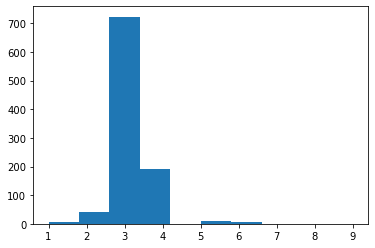

In [20]:
sizes = train.groupby(by="reviewerID").size()
plt.hist(sizes); sizes.describe()

### 4.2
Compute the number of ratings per item in the training set. How does a barplot of the number of ratings ordered by decreasing frequency look like? <br>
Reflect on how it will affect the prediction process of a recommender system if only a small fraction of the items are rated frequently. <br>
<br>
Repeat this exercise on the test set and reflect on how the evaluation of a recommender system can be affected by popular items.

40.166666666666664

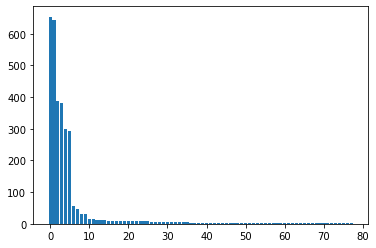

In [21]:
sizes = train.groupby(by="asin").size()
plt.bar(np.arange(len(sizes)), np.sort(sizes)[::-1]); sizes.mean()

16.362068965517242

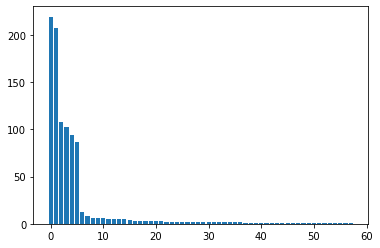

In [22]:
sizes = test.groupby(by="asin").size()
plt.bar(np.arange(len(sizes)), np.sort(sizes)[::-1]); sizes.mean()

### 4.3
Compute the mean rating per user in the training set. What is the summary statistics of the rating means, and how does a histogram look like? <br>
Reflect on how a recommender system can take into account if different users rate on different "scales" (e.i. a rating of $3$ may be high for one user while low for another).<br>
<br>
Repeat this exercise with mean rating per item.

count    981.000000
mean       4.770608
std        0.716419
min        1.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: overall, dtype: float64

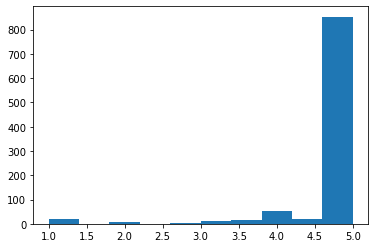

In [23]:
ratings = train.groupby(by=["reviewerID"])["overall"].mean()
plt.hist(ratings)
ratings.describe()

count    78.000000
mean      4.254431
std       0.946571
min       1.000000
25%       4.000000
50%       4.666667
75%       5.000000
max       5.000000
Name: overall, dtype: float64

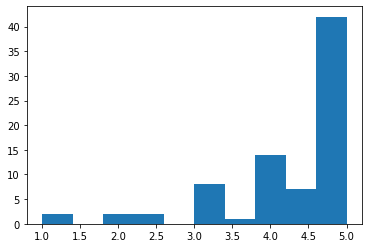

In [24]:
ratings = train.groupby(by=["asin"])["overall"].mean()
plt.hist(ratings); ratings.describe()